# Предсказание ранней повторной госпитализации

Задача состоит в предсказании того, будет ли пациент повторно госпитализован, на основе данных о пациентах с диабетом.

Набор данных [_Diabetes 130-US hospitals for years 1999-2008 Data Set_](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#) представляет 10 лет (1999-2008) клинической помощи в 130 больницах США. Он включает в себя более 50 признаков, представляющих данные больниц и результаты лечения пациентов.

Показатели ранней повторной госпитализации могут служить хорошим признаком качества лекарств и систем здравоохранения в целом. Так частая повторная госпитализация, как правило, означает неэффективность используемых лекарств во время лечения.

Цель: построить некоторую модель, предсказывающую раннюю (в течение месяца) повторную госпитализцаию.

### Импорт нужных модулей

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import imblearn
!pip install category_encoders
import category_encoders as ce  # библиотека для кодирования категориальных признаков
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 987 kB/s 


### Читаем данные

In [2]:
data_url = 'https://raw.githubusercontent.com/AlibekovMurad5202/ML/main/data/diabetic_data.csv'
df = pd.read_csv(data_url)

df.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(101766, 50)

Датасет состоит из _101 766_ записей и _50_ признаков

Посмотрим на загруженный набор данных, отобразив записи в виде таблицы. Т.к. записей много, отобразим лишь часть (первые 5 записей), причем для удобства восприятия (ввиду большого количества признаков) ещё и транспонируем эту таблицу.

In [3]:
df.head(5).T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,NaN,NaN,NaN,NaN,NaN
admission_type,NaN,Emergency,Emergency,Emergency,Emergency
discharge_disposition,Not Mapped,Discharged to home,Discharged to home,Discharged to home,Discharged to home
admission_source,Physician Referral,Emergency Room,Emergency Room,Emergency Room,Emergency Room
time_in_hospital,1,3,2,2,1


Видно, что данные состоят как из числовых, так и категориальных признаков. Помимо этого, также имеются пропущенные значения.
Поэтому датасет требует дополнительную предобработку данных.

## Список признаков и их описания

In [4]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type              object
discharge_disposition       object
admission_source            object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

Заранее поменяем тип у категориальных признаков (с _object_ на _category_)

In [5]:
for column in df.select_dtypes(['object']):
    df[column] = df[column].astype('category')

In [6]:
df.dtypes

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                      category
age                         category
weight                      category
admission_type              category
discharge_disposition       category
admission_source            category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
c

### Входные признаки

####  Числовые признаки

* __encounter_id__ - уникальный идентификатор приема
* __patient_nbr__ - уникальный идентификатор пациента
* __time_in_hospital__ - число дней между поступлением и выпиской
* __num_lab_procedures__ - количество лабораторных тестов, проведенных во время приема
* __num_procedures__ - количество процедур (кроме лабораторных тестов), проведенных во время приема
* __num_medications__ - количество препаратов, назначенных во время приема
* __number_outpatient__ - количество амбулаторных посещений пациента за год, предшествующий приему
* __number_emergency__ - количество экстренных посещений пациента за год, предшествующий приему
* __number_inpatient__ - количество стационарных посещений пациента за год, предшествующий приему
* __number_diagnoses__ - количество диагнозов, введенных в систему

####  Категориальные признаки

* __race__ - расовая принадлежность (принимаемые значения: _Caucasian_, _AfricanAmerican_, _Asian_, _Hispanic_, _Other_)
* __gender__ - пол (принимаемые значения: _male_, _female_, _unknown/invalid_)
* __age__ - возраст (значения сгруппированы с интервалом в 10 лет: _\[0-10)_, _\[10-20)_, ..., _\[90-100)_)
* __weight__ - вес в фунтах (значения сгруппированы с интервалом в 25 фунтов: _\[0-25)_, ... _\[175-200)_, _>200_)
* __admission_type__ - тип посещения (принимает 9 различных значений, например, _emergency_, _urgent_, _elective_, _newborn_ и др.)
* __discharge_disposition__ - расположение пациента на момент выписки (принимает 29 различных значений, например, _discharged to home_, _expired_ и др.)
* __admission_source__ - источник обращения (принимает 21 различное значение, например, _physician referral_, _emergency room_ и др.)
* __payer_code__ - код плательщика, покрывающего медицинские расходы (соответствует 23 различным значениям, например, _Medicare_, _self-pay_ и др.)
* __medical_specialty__ - медицинская специальность принимающего врача (соответствует 84 различным значениям, например, _cardiology_, _surgeon_ и др.)
* __diag_1__ - первичный диагноз (кодируется первыми тремя цифрами МКБ9 и принимает 848 различных значений)
* __diag_2__ - вторичный диагноз (кодируется первыми тремя цифрами МКБ9 и принимает 923 различных значения)
* __diag_3__ - дополнительный вторичный диагноз (кодируется первыми тремя цифрами МКБ9 и принимает 954 различных значения)
* __max_glu_serum__ - диапазон результата теста на глюкозу в сыворотке крови (значения: _None_, _>200_, _>300_, _Norm_)
* __A1Cresult__ - диапазон результата теста A1C (тест на гемоглобин) (значения: _None_, _>7_, _>8_, _Norm_)
* __change__ - признак, показывающий было ли изменение лекарств от диабета (либо дозировки, либо препарата) (значения: _change_, _no change_)
* __diabetesMed__ - признак, показывающий были ли назначены лекарства от диабета (значения: _yes_, _no_)
* __metformin__, ..., __metformin-pioglitazone__ - 24 признака, показывающих был ли назначен соответствующий препарат или произошло ли изменение дозировки (значения: _up_ (если увеличили дозировку), _down_ (если уменьшили дозировку), _steady_ (если дозировку не меняли), _no_ (если препарат не был назначен))

### Выходной признак

* __readmitted__ - категориальный признак, показывающий число дней до повторной госпитализации в стационар (принимаемые значения: _<30_ (если пациент был повторно госпитализирован менее чем за 30 дней), _>30_ (если пациент был повторно госпитализирован более чем за 30 дней), _No_ (для отсутствия записи о повторной госпитализации))

## Описание задачи

Данная задача - __предсказание ранней повторной госпитализации__. Признак __readmitted__ показывает число дней до повторной госпитализации. Т.к. в данной задаче важна именно ранняя госпитализация, то можно объединить значения _>30_ и _No_ в единое значение и заменить его на _NO_, а значение _\<30_ - на _YES_, тем самым сведя задачу к __бинарной классификации__.

In [7]:
df['readmitted'].unique()  # число уникальных значений признака readmitted

['NO', '>30', '<30']
Categories (3, object): ['<30', '>30', 'NO']

In [8]:
df['readmitted'] = df['readmitted'].replace('<30', 'YES').replace('>30', 'NO')

In [9]:
df['readmitted'].unique()

['NO', 'YES']
Categories (2, object): ['YES', 'NO']

In [10]:
df.head(5).T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,NaN,NaN,NaN,NaN,NaN
admission_type,NaN,Emergency,Emergency,Emergency,Emergency
discharge_disposition,Not Mapped,Discharged to home,Discharged to home,Discharged to home,Discharged to home
admission_source,Physician Referral,Emergency Room,Emergency Room,Emergency Room,Emergency Room
time_in_hospital,1,3,2,2,1


## Визуализация и предварительный анализ данных

Для начала избавляемся от идентификаторов пациента и приема, потому что никакой смысловой нагрузки они не несут

In [11]:
df.drop(['patient_nbr', 'encounter_id'], axis=1, inplace=True)

In [12]:
df.shape

(101766, 48)

### Описательная статистика матрицы данных

#### Информация о категориальных признаках

In [13]:
df.describe(include=['category']).T

,count,unique,top,freq
race,99493,5,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
weight,3197,9,[75-100),1336
admission_type,96475,7,Emergency,53990
discharge_disposition,98075,25,Discharged to home,60234
admission_source,94985,16,Emergency Room,57494
payer_code,61510,17,MC,32439
medical_specialty,51817,72,InternalMedicine,14635
diag_1,101745,716,428,6862


Видно, что признаки _examide_, _citoglipton_ принимают только одно уникальное значение, а, следовательно, их можно убрать из таблицы

In [14]:
df.drop(['examide', 'citoglipton'], axis=1, inplace=True)

In [15]:
df.shape

(101766, 46)

#### Информация о числовых признаках

In [16]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


По таблице можно заметить, что каких-то явно "выбивающихся", бессмысленных значений нет. Потому можно сделать вывод, что выбросов нет.

### Визуализация данных

В процессе визуализации могут проявиться некоторые особенности данных, с которыми необходимо будет разобраться

Посмотрим на сбалансированность/несбалансированность классов

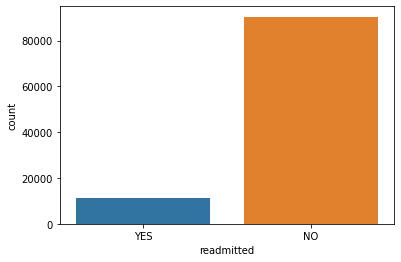

In [17]:
sns.countplot(x='readmitted', data=df)
pass

Видно, что классы ___несбалансированны___. Впоследствии имеет смысл попытаться избавиться от несбалансированности.

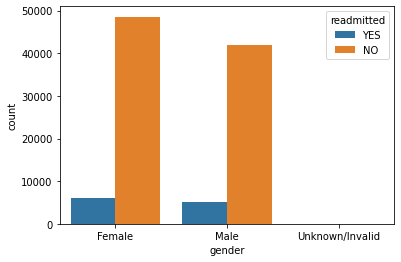

In [18]:
sns.countplot(x='gender', order=df['gender'].value_counts().index, hue='readmitted', data=df)
pass

В датасете женщин больше, к тому же есть невалидные значения, от которых лучше избавиться

In [19]:
rows_with_invalid_gender = df[df['gender'] == 'Unknown/Invalid']  # строки с невалидными значениями признака gender

len(rows_with_invalid_gender)  # число таких строк

3

Таких значений немного, поэтому можно их просто удалить (удалить эти строки из таблицы)

In [20]:
df.drop(rows_with_invalid_gender.index, axis=0, inplace=True)  # удаляем из таблицы

len(df[df['gender'] == 'Unknown/Invalid'])  # число строк с невалидными значениями признака gender после удаления

0

Посмотрим на возраст повторно госпитализируемых

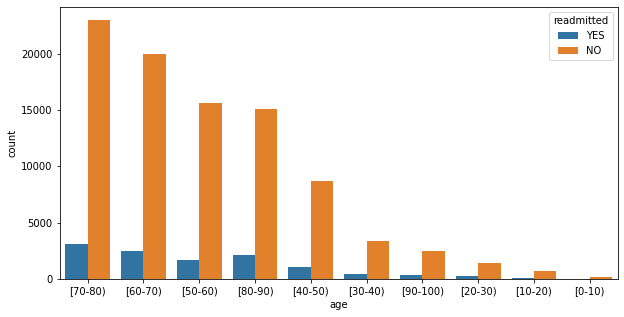

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(x='age', order=df['age'].value_counts().index, hue='readmitted', data=df)
pass

Видим, что наиболее частыми пациентами являются пожилые люди, причем как среди тех, кто был, так и среди тех, кто не был повторно госпитализирован. Отсюда возникает интересный вопрос, связанный с тем, как именно оплачиваются медицинские услуги. Учитываю возрастное распределение среди пациентов, можно предположить, что большинство пациентов оплачивало медуслуги по страховке ([Medicare](https://en.wikipedia.org/wiki/Medicare_(United_States)))

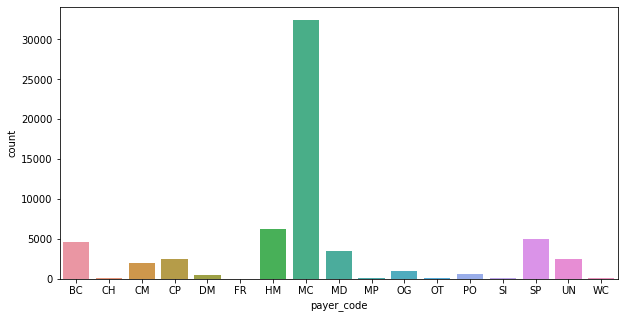

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(x='payer_code', data=df)
pass

Действительно, самый популярный способ оплаты медуслуг - MC (медицинская страховка для лиц от 65 лет и старше)

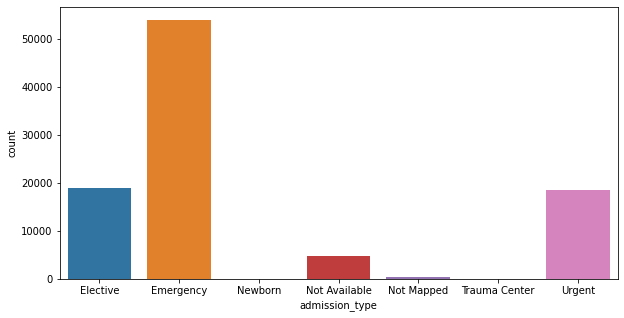

In [23]:
plt.figure(figsize=(10, 5))
sns.countplot(x='admission_type', data=df)
pass

Заметим, что наибольшее число обращений было неотложным, что вполне логично, учитывая возраст пациентов

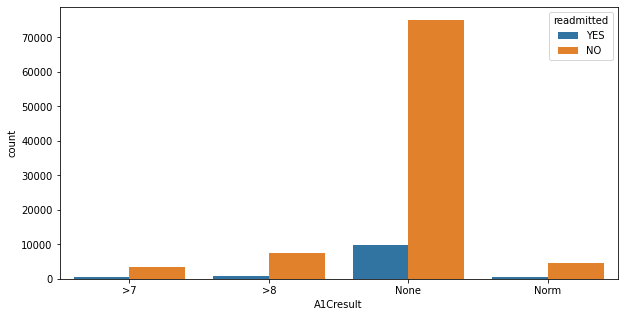

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(x='A1Cresult', hue='readmitted', data=df)
pass

Подавляющей части пациентов не делали теста на гемоглобин (A1C)

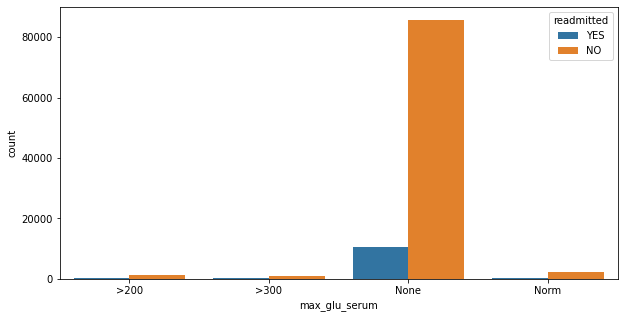

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(x='max_glu_serum', hue='readmitted', data=df)
pass

Аналогичная ситуация и с тестами на глюкозу

Построим графики зависимостей каждого количественного признака с каждым

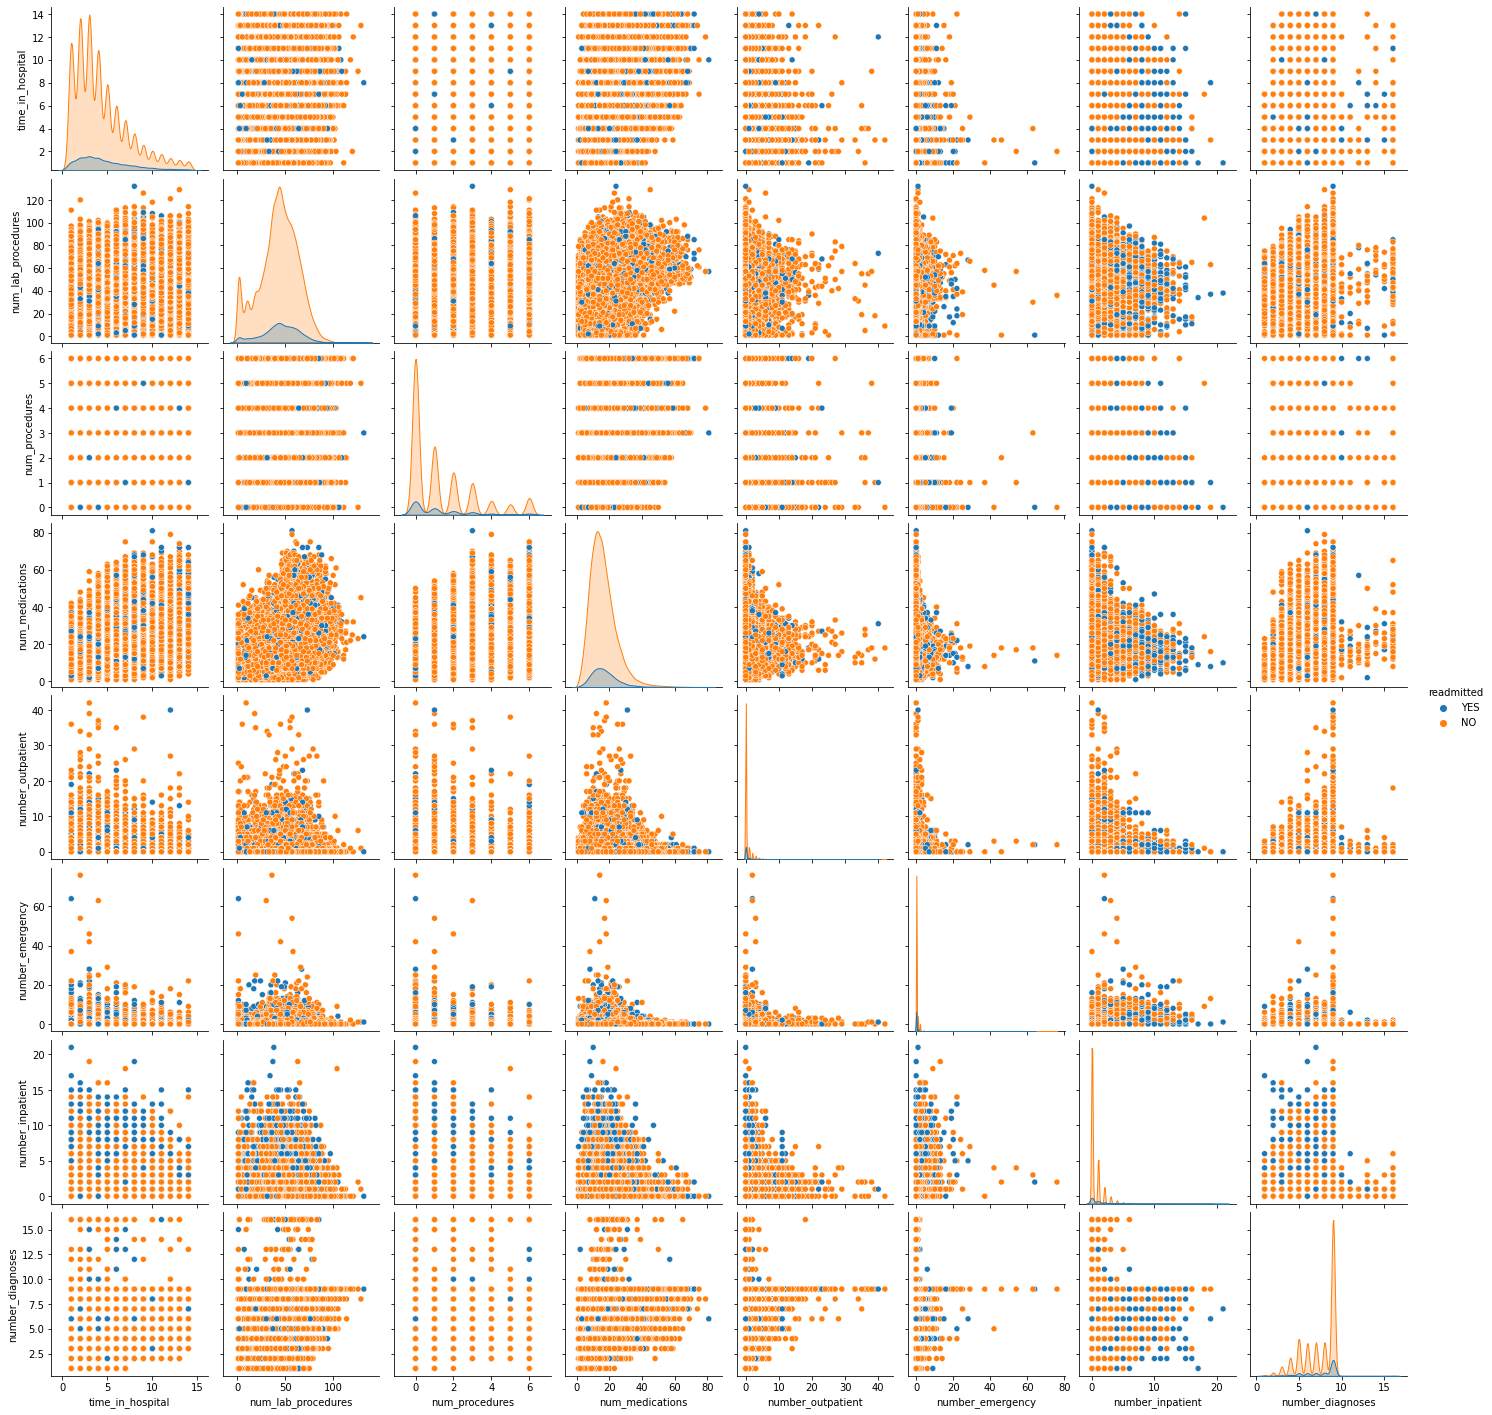

In [26]:
sns.pairplot(df, hue='readmitted')

Построим матрицу корреляции для количественных признаков и визуализируем её

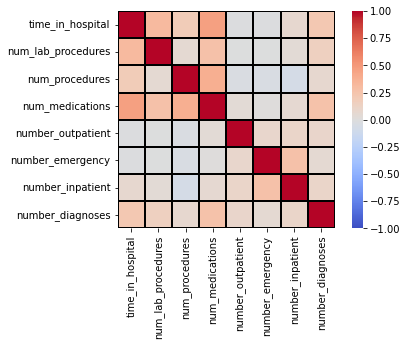

In [27]:
corr_mat = df.corr()

sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=1, linecolor="black")
pass

Видно, что среди количественных признаков сильно скореллированных не оказалось

Попробуем вычислить матрицу корреляции для всех признаков, но перед этим временно факторизируем категориальные признаки

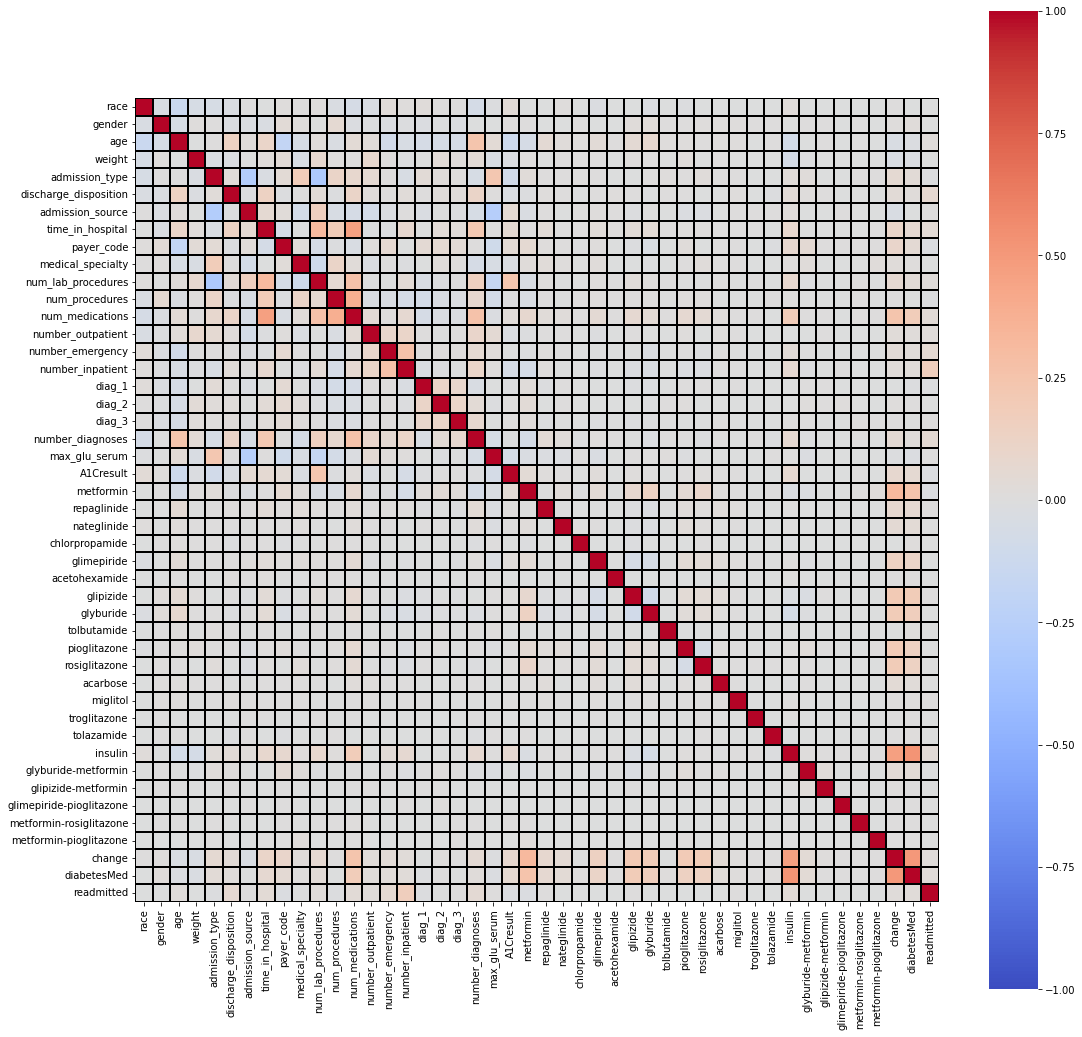

In [28]:
df_f = df.copy()
for column in df_f.select_dtypes(['category']):
    df_f[column] = pd.factorize(df_f[column])[0]

corr_mat_f = df_f.corr()

plt.figure(figsize=(18, 18))
sns.heatmap(corr_mat_f, square=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=1, linecolor="black")
pass

Видим, что и среди всех признаков сильно скореллированных нет

Выведем пары признаков, для которых коэффициенты корреляции, больше заданного значения

In [29]:
corr_mat_f.where(np.triu(corr_mat_f > 0.4, k=1)).stack().sort_values(ascending=False)

insulin           diabetesMed        0.528249
change            diabetesMed        0.506360
insulin           change             0.468251
time_in_hospital  num_medications    0.466137
dtype: float64

Несмотря на то, что сильной связи между признаками нет, всё же существует средняя связь между _insulin_, _change_, _diabetesMed_, по той причине, что инсулин назначали как лекарство от диабета, а также между _time_in_hospital_ и _num_medications_, т.к. чем больше времени пациент проводит в больнице (по тем или иным причинам, оставаясь при этом именно пациентом), тем больше лекарств нужно, чтобы его исцелить.

## Обработка пропущенных значений

Оценим, сколько пропущенных значений содержится в данном датасете. Для этого посмотрим на процентное содержание пропущенных значений.

In [30]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False)

weight                      96.858387
medical_specialty           49.081690
payer_code                  39.557600
admission_source             6.663522
admission_type               5.199336
discharge_disposition        3.627055
race                         2.231656
diag_3                       1.398347
diag_2                       0.351798
diag_1                       0.020636
pioglitazone                 0.000000
tolbutamide                  0.000000
rosiglitazone                0.000000
acarbose                     0.000000
miglitol                     0.000000
troglitazone                 0.000000
tolazamide                   0.000000
glipizide-metformin          0.000000
insulin                      0.000000
glyburide-metformin          0.000000
glipizide                    0.000000
glimepiride-pioglitazone     0.000000
metformin-rosiglitazone      0.000000
metformin-pioglitazone       0.000000
change                       0.000000
diabetesMed                  0.000000
glyburide   

Видим, что есть как признаки, в которых нет пропущенных значений, так и те признаки, в которых пропущено >90% значений. Также заметим, что для числовых признаков нет пропущенных значений.

Ввиду того, что для признаков _race_, _diag_3_, _diag_2_, _diag_1_ мало пропущенных значений (<3%), можно удалить из таблицы все строки, в которых встречаются соответствующие отсутствующие значения.

In [31]:
df.dropna(subset=['race', 'diag_3', 'diag_2', 'diag_1'], inplace=True)
df.shape

(98052, 46)

Имеет смысл удалить признак _payer_code_, для которого пропущено почти 40% записей по той причине, что он, очевидно, никак не влияет на физическое состояние пациента и будет несущественным в задаче предсказания ранней повторной госпитализации

In [32]:
df.drop(['payer_code'], axis=1, inplace=True)
df.shape

(98052, 45)

Признак _weight_ также придется удалить, потому что он отсутствует почти во всех записях (почти 97%) и его невозможно восстановить

In [33]:
df.drop(['weight'], axis=1, inplace=True)
df.shape

(98052, 44)

Для признаков _admission_source_ и _admission_type_ есть специальное значение _'Not Available'_, на которое можно заменить пропущенные значения

In [34]:
df['admission_source'].fillna('Not Available', inplace=True)
df['admission_type'].fillna('Not Available', inplace=True)

А для оставшихся признаков _discharge_disposition_ и _medical_specialty_ имеет смысл специально добавить значение _'Not Available'_, на которое заменим пропущенные значения

In [35]:
df['discharge_disposition'] = df['discharge_disposition'].cat.add_categories('Not Available')
df['discharge_disposition'].fillna('Not Available', inplace=True)

df['medical_specialty'] = df['medical_specialty'].cat.add_categories('Not Available')
df['medical_specialty'].fillna('Not Available', inplace=True)

In [36]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False)

race                        0.0
gender                      0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglitazone                0.0
rosiglitazone               0.0
acarbose                    0.0
miglitol                    0.0
troglitazone                0.0
tolazamide                  0.0
insulin                     0.0
glyburide-metformin         0.0
glipizide-metformin         0.0
glimepiride-pioglitazone    0.0
metformin-rosiglitazone     0.0
metformin-pioglitazone      0.0
change                      0.0
diabetesMed                 0.0
chlorpropamide              0.0
nateglinide                 0.0
repaglinide                 0.0
num_medications             0.0
age                         0.0
admission_type              0.0
discharge_disposition       0.0
admission_source            0.0
time_in_hospital            0.0
medical_specialty           0.0
num_lab_

In [37]:
df.describe(include=['category']).T

,count,unique,top,freq
race,98052,5,Caucasian,75079
gender,98052,2,Female,52833
age,98052,10,[70-80),25305
admission_type,98052,7,Emergency,52178
discharge_disposition,98052,26,Discharged to home,57609
admission_source,98052,16,Emergency Room,55951
medical_specialty,98052,73,Not Available,48318
diag_1,98052,713,428,6730
diag_2,98052,740,428,6517
diag_3,98052,786,250,11208


Заметим, что после обработки пропущенных значений _metformin-rosiglitazone_ стал принимать только одно уникальное значение, а потому этот признак можно убрать из таблицы

In [38]:
df.drop(['metformin-rosiglitazone'], axis=1, inplace=True)

df.shape

(98052, 43)

## Обработка категориальных признаков

### Получение числового признака _age_ из категориального

Сначала обработаем признак _age_. Он принимает значения в виде 10-летнего интервала, а потому имеет смысл заменить интервал на среднее значение интервала, тем самым получив числовой признак

In [39]:
df['age'].unique()

['[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)', '[0-10)']
Categories (10, object): ['[0-10)', '[10-20)', '[20-30)', '[30-40)', ..., '[60-70)', '[70-80)',
                          '[80-90)', '[90-100)']

Все интервалы выглядят следующим образом: $[10 * i; 10 * (i + 1))$ для всех i от 0 до 9. Соответственно, каждый такой интервал можно заменить на $10*i + 5*(i+1)$ для всех i от 0 до 9

In [40]:
age = df['age'].copy()

for i in range(0, 10):
    interval_str = '[' + str(10 * i) + '-' + str(10 * (i + 1)) + ')'
    mean_of_interval = 10 * i + 10 * (i + 1) // 2
    age = age.replace(interval_str, mean_of_interval)  # заменяем интервал на среднее

age = pd.to_numeric(age)  # меняем тип на числовой
df.drop(['age'], axis=1, inplace=True)  # удаляем из исходной таблицы старый категориальный признак age
df = pd.concat([age, df], axis=1)  # добавляем новый числовой признак age

In [41]:
df.dtypes

age                            int64
race                        category
gender                      category
admission_type              category
discharge_disposition       category
admission_source            category
time_in_hospital               int64
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
glimepiride                 category
acetohexamide               category
glipizide                   category
g

Будет правильным решением сейчас отдельно сохранить таблицу исключительно с количественными признаками (тех, для которых на данный момент dtype == int64). Впоследствии это облегчит процесс нормализации данных, т.к. нормализируем мы только количественные признаки.

In [42]:
df_num = df.select_dtypes(['int64'])  # num - сокращение от numeric

In [43]:
df_num

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
1,20,3,59,0,18,0,0,0,9
2,35,2,11,5,13,2,0,1,6
3,50,2,44,1,16,0,0,0,7
4,65,1,51,0,8,0,0,0,5
5,80,3,31,6,16,0,0,0,9
...,...,...,...,...,...,...,...,...,...
101761,110,3,51,0,16,0,0,0,9
101762,125,5,33,3,18,0,0,1,9
101763,110,1,53,0,9,1,0,0,13
101764,125,10,45,2,21,0,0,1,9


Сейчас можно временно удалить из исходной таблицы все количественные признаки. После обработки категориальных признаков, можно будет объединить всё обратно в единую таблицу

In [44]:
df.drop(df_num, axis=1, inplace=True)

### Предварительная категоризация заболеваний

In [45]:
len(df['diag_1'].unique())

713

In [46]:
len(df['diag_2'].unique())

740

In [47]:
len(df['diag_3'].unique())

786

Для признаков _diag_1_, _diag_2_, _diag_3_ слишком много уникальных значений (>700). Т.к. эти признаки обозначают диагноз (заболевание), то имеет смысл сгруппировать эти болезни в следующие категории:

* ___Circulatory___ - Заболевания системы кровообращения (коды МКБ9: __390–459__, __785__)
* ___Respiratory___ - Заболевания дыхательной системы (коды МКБ9: __460–519__, __786__)
* ___Digestive___ - Заболевания пищеварительной системы (коды МКБ9: __520–579__, __787__)
* ___Diabetes___ - Сахарный диабет (коды МКБ9: __250.xx__)
* ___Injury___ - Травмы и отравления (коды МКБ9: __800–999__)
* ___Musculoskeletal___ - Заболевания опорно-двигательного аппарата и соединительной ткани (коды МКБ9: __710–739__)
* ___Genitourinary___ - Заболевания мочеполовой системы (коды МКБ9: __580–629__, __788__)
* ___Neoplasms___ - Новообразования (коды МКБ9: __140–239__)
* ___Other___ - Другие заболевания, не принадлежащие ни одной из вышеперечисленных категорий

Также, как и с числовыми признаками, скопируем часть исходной таблицы с признаками _diag_1_, _diag_2_, _diag_3_

In [48]:
diags = ['diag_1', 'diag_2', 'diag_3']

df_diags = df[diags].copy()

In [49]:
diag_categories = [
    'Circulatory', 
    'Respiratory', 
    'Digestive', 
    'Diabetes', 
    'Injury', 
    'Musculoskeletal', 
    'Genitourinary', 
    'Neoplasms', 
    'Other'
]

for diag in diags:
    df_diags[diag] = df_diags[diag].cat.set_categories(diag_categories)

Для удобства можно ввести функцию, принимающую на вход код МКБ9 (ICD9), а на выходе возвращающую название категории заболевания. Но не смотря на то, что мы избавились от пропущенных значений, все же есть валидные коды, начинающиеся с _'E'_ и _'V'_. Эти заболевания должны быть отнесены к категории _'Other'_.

In [50]:
def get_diag_category(icd9_code: str) -> str:
    if icd9_code[0] == 'E' or icd9_code[0] == 'V':
        return 'Other'
    
    icd9_code = int(float(icd9_code))
    
    if 390 <= icd9_code <= 459 or icd9_code == 785:
        return 'Circulatory'
    if 460 <= icd9_code <= 519 or icd9_code == 786:
        return 'Respiratory'
    if 520 <= icd9_code <= 579 or icd9_code == 787:
        return 'Digestive'
    if icd9_code == 250:
        return 'Diabetes'
    if 800 <= icd9_code <= 999:
        return 'Injury'
    if 710 <= icd9_code <= 739:
        return 'Musculoskeletal'
    if 580 <= icd9_code <= 629 or icd9_code == 788:
        return 'Genitourinary'
    if 140 <= icd9_code <= 239:
        return 'Neoplasms'
    
    return 'Other'

Перебирая все строки исходной таблицы, с помощью функции _get_diag_category()_ заполняем новую таблицу с признаками diag_1, diag_2, diag_3

In [51]:
for index, row in df.iterrows():
    for diag in diags:
        df_diags.loc[index, diag] = get_diag_category(df.loc[index, diag])

In [52]:
df_diags.T

,1,2,3,4,5,6,7,8,9,10,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
diag_1,Other,Other,Other,Neoplasms,Circulatory,Circulatory,Circulatory,Circulatory,Circulatory,Diabetes,...,Injury,Respiratory,Other,Circulatory,Other,Diabetes,Digestive,Other,Injury,Digestive
diag_2,Diabetes,Diabetes,Diabetes,Neoplasms,Circulatory,Circulatory,Respiratory,Circulatory,Neoplasms,Circulatory,...,Genitourinary,Respiratory,Other,Other,Circulatory,Other,Other,Genitourinary,Other,Digestive
diag_3,Other,Other,Circulatory,Diabetes,Diabetes,Other,Diabetes,Other,Respiratory,Injury,...,Circulatory,Respiratory,Other,Diabetes,Circulatory,Circulatory,Digestive,Other,Injury,Digestive


Т.к. мы разбили все заболевания на различные категории, а признаки могут принимать значения не всех кодов заболеваний, возникают неиспользуемые категории. От них следует избавиться, чтобы в последующем (при кодировании) уменьшить размерности векторов.

In [53]:
for diag in diags:
    df_diags[diag] = df_diags[diag].cat.remove_unused_categories()

Теперь заменяем "старые" признаки _diag_1_, _diag_2_, _diag_3_ на их "новые" аналоги.

In [54]:
df.drop(diags, axis=1, inplace=True)    # удаляем из исходной таблицы "старые" признаки diag_1, diag_2, diag_3
df = pd.concat([df, df_diags], axis=1)  # добавляем новые признаки diag_1, diag_2, diag_3

In [55]:
df.describe(include=['category']).T

,count,unique,top,freq
race,98052,5,Caucasian,75079
gender,98052,2,Female,52833
admission_type,98052,7,Emergency,52178
discharge_disposition,98052,26,Discharged to home,57609
admission_source,98052,16,Emergency Room,55951
medical_specialty,98052,73,Not Available,48318
max_glu_serum,98052,4,None,92844
A1Cresult,98052,4,None,81859
metformin,98052,4,No,78807
repaglinide,98052,4,No,96529


### Кодирование номинальных  признаков

Сначала все бинарные признаки заменим на числовые (0 и 1)

In [56]:
cat_columns = df.select_dtypes(['category'])

for column in cat_columns:
    if df[column].nunique() == 2:
        df[column] = pd.factorize(df[column])[0]

In [57]:
df.describe(include=['category']).T

,count,unique,top,freq
race,98052,5,Caucasian,75079
admission_type,98052,7,Emergency,52178
discharge_disposition,98052,26,Discharged to home,57609
admission_source,98052,16,Emergency Room,55951
medical_specialty,98052,73,Not Available,48318
max_glu_serum,98052,4,None,92844
A1Cresult,98052,4,None,81859
metformin,98052,4,No,78807
repaglinide,98052,4,No,96529
nateglinide,98052,4,No,97361


Все признаки, кроме _discharge_disposition_, _admission_source_ и _medical_specialty_, содержат число уникальных значений >2 и <10, а, значит, для их кодирования логично применить метод бинаризации (one-hot encoding), предварительно убрав неиспользуемые категории

In [58]:
cat_columns = df.select_dtypes(['category'])

for column in cat_columns:
    if df[column].nunique() < 10:
        df[column] = df[column].cat.remove_unused_categories()  # убираю неиспользуемые категории
        df_dummies = pd.get_dummies(df[column], prefix=column)  # one-hot encoding
        df.drop(column, axis=1, inplace=True)                   # удаляем из исходной таблицы "старые" признаки
        df = pd.concat([df, df_dummies], axis=1)                # добавляем бинаризованные ("новые") признаки

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,98052.0,0.461174,0.498493,0.0,0.0,0.0,1.0,1.0
acetohexamide,98052.0,0.000010,0.003194,0.0,0.0,0.0,0.0,1.0
tolbutamide,98052.0,0.000224,0.014977,0.0,0.0,0.0,0.0,1.0
troglitazone,98052.0,0.000031,0.005531,0.0,0.0,0.0,0.0,1.0
glipizide-metformin,98052.0,0.000133,0.011514,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
diag_3_Injury,98052.0,0.019275,0.137492,0.0,0.0,0.0,0.0,1.0
diag_3_Musculoskeletal,98052.0,0.018990,0.136490,0.0,0.0,0.0,0.0,1.0
diag_3_Genitourinary,98052.0,0.066567,0.249271,0.0,0.0,0.0,0.0,1.0
diag_3_Neoplasms,98052.0,0.018562,0.134971,0.0,0.0,0.0,0.0,1.0


Признаки _discharge_disposition_, _admission_source_ и _medical_specialty_ содержат большое число уникальных значений, поэтому рассмотренные выше методы для кодирования не годятся. Для кодирования применим метод бинарного кодирования из библиотеки _category_encoders_

Кодируем признак _discharge_disposition_ и заменяем "старый" признак "новым" кодированным.

In [60]:
encoder = ce.BinaryEncoder(return_df=True)
df_discharge_disposition = encoder.fit_transform(df['discharge_disposition'])
df_discharge_disposition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   discharge_disposition_0  98052 non-null  int64
 1   discharge_disposition_1  98052 non-null  int64
 2   discharge_disposition_2  98052 non-null  int64
 3   discharge_disposition_3  98052 non-null  int64
 4   discharge_disposition_4  98052 non-null  int64
dtypes: int64(5)
memory usage: 4.5 MB


In [61]:
df.drop(['discharge_disposition'], axis=1, inplace=True)
df = pd.concat([df, df_discharge_disposition], axis=1)

Кодируем признак _admission_source_ и заменяем "старый" признак "новым" кодированным.

In [62]:
encoder = ce.BinaryEncoder(return_df=True)
df_admission_source = encoder.fit_transform(df['admission_source'])
df_admission_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   admission_source_0  98052 non-null  int64
 1   admission_source_1  98052 non-null  int64
 2   admission_source_2  98052 non-null  int64
 3   admission_source_3  98052 non-null  int64
 4   admission_source_4  98052 non-null  int64
dtypes: int64(5)
memory usage: 4.5 MB


In [63]:
df.drop(['admission_source'], axis=1, inplace=True)
df = pd.concat([df, df_admission_source], axis=1)

Кодируем признак _medical_specialty_ и заменяем "старый" признак "новым" кодированным.

In [64]:
encoder = ce.BinaryEncoder(return_df=True)
df_medical_specialty = encoder.fit_transform(df['medical_specialty'])
df_medical_specialty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   medical_specialty_0  98052 non-null  int64
 1   medical_specialty_1  98052 non-null  int64
 2   medical_specialty_2  98052 non-null  int64
 3   medical_specialty_3  98052 non-null  int64
 4   medical_specialty_4  98052 non-null  int64
 5   medical_specialty_5  98052 non-null  int64
 6   medical_specialty_6  98052 non-null  int64
dtypes: int64(7)
memory usage: 6.0 MB


In [65]:
df.drop(['medical_specialty'], axis=1, inplace=True)
df = pd.concat([df, df_medical_specialty], axis=1)

In [66]:
df.describe()

,gender,acetohexamide,tolbutamide,troglitazone,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,...,admission_source_2,admission_source_3,admission_source_4,medical_specialty_0,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,medical_specialty_5,medical_specialty_6
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,...,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,0.461174,0.000010,0.000224,0.000031,0.000133,0.000010,0.000010,0.538225,0.231530,0.112858,...,0.318984,0.061702,0.678915,0.000938,0.032014,0.044456,0.154041,0.225136,0.277802,0.671450
std,0.498493,0.003194,0.014977,0.005531,0.011514,0.003194,0.003194,0.498539,0.421813,0.316421,...,0.466085,0.240615,0.466896,0.030617,0.176037,0.206107,0.360990,0.417674,0.447917,0.469688
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Нормализация количественных признаков

Проведем стандартизацию (линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению) всех признаков

In [67]:
df_num = (df_num - df_num.mean(axis=0)) / df_num.std(axis=0)

In [68]:
df_num.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04
mean,4.058091e-17,2.087018e-17,-1.791357e-16,5.543642e-18,9.855364e-17,1.159455e-18,2.782691e-17,8.319086e-17,-1.669615e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.929255e+00,-1.143311e+00,-2.138240e+00,-7.905951e-01,-1.864660e+00,-2.932773e-01,-2.147255e-01,-5.089364e-01,-2.462300e+00
25%,-7.222366e-01,-8.092063e-01,-6.163054e-01,-7.905951e-01,-6.313859e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,-8.251672e-01
50%,-8.083288e-02,-1.409960e-01,4.319950e-02,-2.052777e-01,-1.380761e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,2.662548e-01
75%,5.605708e-01,5.272143e-01,7.027044e-01,3.800396e-01,4.785611e-01,-2.932773e-01,-2.147255e-01,2.778300e-01,8.119658e-01
max,1.843378e+00,3.200055e+00,4.507540e+00,2.721309e+00,8.001535e+00,3.243318e+01,8.038794e+01,1.601316e+01,4.631943e+00


Теперь объединим стандартизованные количественные признаки с уже обработанными категориальными признаками

In [69]:
df = pd.concat([df_num, df], axis=1)

In [70]:
df.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,gender,...,admission_source_2,admission_source_3,admission_source_4,medical_specialty_0,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,medical_specialty_5,medical_specialty_6
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,98052.000000,...,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,4.058091e-17,2.087018e-17,-1.791357e-16,5.543642e-18,9.855364e-17,1.159455e-18,2.782691e-17,8.319086e-17,-1.669615e-16,0.461174,...,0.318984,0.061702,0.678915,0.000938,0.032014,0.044456,0.154041,0.225136,0.277802,0.671450
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.498493,...,0.466085,0.240615,0.466896,0.030617,0.176037,0.206107,0.360990,0.417674,0.447917,0.469688
min,-3.929255e+00,-1.143311e+00,-2.138240e+00,-7.905951e-01,-1.864660e+00,-2.932773e-01,-2.147255e-01,-5.089364e-01,-2.462300e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.222366e-01,-8.092063e-01,-6.163054e-01,-7.905951e-01,-6.313859e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,-8.251672e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.083288e-02,-1.409960e-01,4.319950e-02,-2.052777e-01,-1.380761e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,2.662548e-01,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.605708e-01,5.272143e-01,7.027044e-01,3.800396e-01,4.785611e-01,-2.932773e-01,-2.147255e-01,2.778300e-01,8.119658e-01,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.843378e+00,3.200055e+00,4.507540e+00,2.721309e+00,8.001535e+00,3.243318e+01,8.038794e+01,1.601316e+01,4.631943e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Отбор признаков

В качестве целевого признака выберем признак _readmitted_

In [71]:
X = df.drop(['readmitted'], axis=1)
y = df['readmitted']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 58)

X_train.shape, X_test.shape

((73539, 137), (24513, 137))

## Попытки борьбы с несбалансированностью классов

Для борьбы с дизбалансом воспользуемся последовательно двумя подходами. Сначала _oversampling_ (увеличение количества примеров миноритарного), т.е. алгоритмом SMOTE расширим имеющийся датасет синтетическими данными с меткой миноритарного класса. Тут нужно быть осторожными, т.к. данные - медицинские и при генерации искусственных данных могут возникнуть примеры, не встречающиеся в реальной жизни, однако применительно к данному датасету вероятно можно применить данный метод (ввиду того, что для каждого признака возможны все промежуточные состояния между встречающимися в наборе, и, интуитивно, разные признаки друг другу не противоречат, а потому "возможно все", однако диплома мед.университета у меня нет и гарантировать, что это действительно так, вообще говоря, нельзя, можно лишь предположить). Затем удалим некоторое количества примеров мажоритарного класса, т.е. используем _undersampling_ подход.

In [73]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over_sampler = SMOTE(sampling_strategy=0.2)
X_train_smote, y_train_smote = over_sampler.fit_resample(X_train, y_train)

under_sampler = RandomUnderSampler(sampling_strategy=0.8)
X_train_bal, y_train_bal = under_sampler.fit_resample(X_train_smote, y_train_smote)

In [74]:
count_minor_before = np.sum(y_train == 1)
print("Original dataset: \t'YES': {} \t'NO': {}".format(count_minor_before, len(y_train) - count_minor_before))

count_minor_after = np.sum(y_train_bal == 1)
print("Balanced dataset: \t'YES': {} \t'NO': {}".format(count_minor_after, len(y_train_bal) - count_minor_after))

Original dataset: 	'YES': 8365 	'NO': 65174
Balanced dataset: 	'YES': 13034 	'NO': 16292


Обучим различные классификаторы на оригинальных и сбалансированных данных

## Обучение классификаторов

In [75]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

### Метод kNN

#### Для оригинальных данных

Обучаем _kNN_-классификатор по умолчанию (для ___k = 5___):

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Вычисляем ошибку на тренировочной выборке

In [77]:
%%time
y_train_pred = knn_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 89.36%
         Error on train data: 10.64%
CPU times: user 3min 6s, sys: 5.6 s, total: 3min 12s
Wall time: 2min 29s


Вычисляем ошибку на тестовой выборке

In [78]:
%%time
y_test_pred = knn_model.predict(X_test)
print('Accuracy score on test data:  {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test data:  {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test data:  88.10%
         Error on test data:  11.90%
CPU times: user 1min 1s, sys: 1.74 s, total: 1min 3s
Wall time: 51.7 s


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


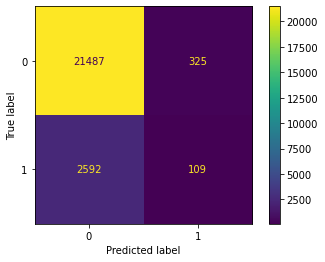

In [79]:
plot_confusion_matrix(knn_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Обучим несколько _kNN_-классификаторов для разных значений _k_ от 5 до 50 с шагом 5, при этом будем собирать значения полученных ошибок, чтобы потом проанализировать результаты.

In [80]:
%%time

acc_train = []
err_train = []
acc_test = []
err_test = []

k_values = range(5, 51, 5)

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    print('k = {}:'.format(k))
    
    y_train_pred = knn_model.predict(X_train)
    print('    Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
    print('             Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))
    acc_train.append(accuracy_score(y_train, y_train_pred))
    err_train.append(np.mean(y_train != y_train_pred))
    
    y_test_pred = knn_model.predict(X_test)
    print('    Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
    print('             Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))
    acc_test.append(accuracy_score(y_test, y_test_pred))
    err_test.append(np.mean(y_test != y_test_pred))

k = 5:
    Accuracy score on train data: 89.36%
             Error on train data: 10.64%
    Accuracy score on test  data: 88.10%
             Error on test  data: 11.90%
k = 10:
    Accuracy score on train data: 88.82%
             Error on train data: 11.18%
    Accuracy score on test  data: 88.89%
             Error on test  data: 11.11%
k = 15:
    Accuracy score on train data: 88.77%
             Error on train data: 11.23%
    Accuracy score on test  data: 88.90%
             Error on test  data: 11.10%
k = 20:
    Accuracy score on train data: 88.69%
             Error on train data: 11.31%
    Accuracy score on test  data: 89.00%
             Error on test  data: 11.00%
k = 25:
    Accuracy score on train data: 88.69%
             Error on train data: 11.31%
    Accuracy score on test  data: 88.97%
             Error on test  data: 11.03%
k = 30:
    Accuracy score on train data: 88.68%
             Error on train data: 11.32%
    Accuracy score on test  data: 88.97%
          

Посмотрим на графики за значениями точности и ошибки на тренировочном и тестовом наборах при различных значениях k

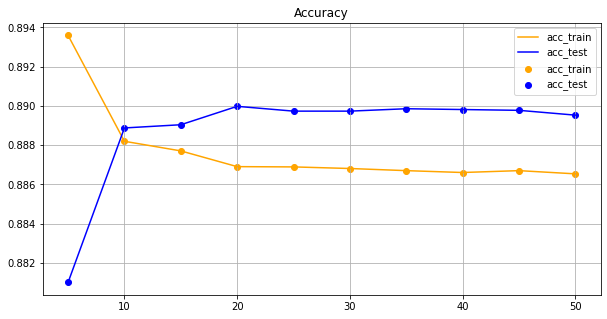

In [81]:
fig = plt.figure(figsize=(10, 5))

plt.title('Accuracy')
plt.scatter(list(k_values)[::-1], acc_train[::-1], color='orange', label='acc_train')
plt.plot(list(k_values)[::-1], acc_train[::-1], color='orange', label='acc_train')

plt.scatter(list(k_values)[::-1], acc_test[::-1], color='blue', label='acc_test')
plt.plot(list(k_values)[::-1], acc_test[::-1], color='blue', label='acc_test')

plt.grid()
plt.legend()

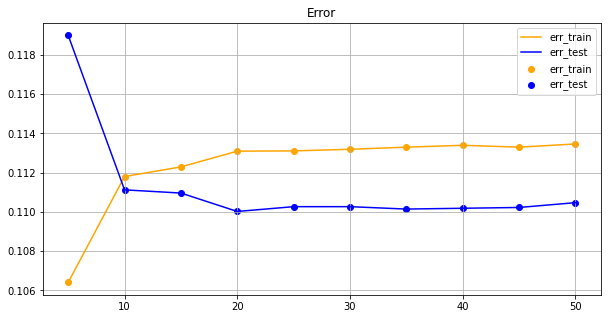

In [82]:
fig = plt.figure(figsize=(10, 5))

plt.title('Error')
plt.scatter(list(k_values)[::-1], err_train[::-1], color='orange', label='err_train')
plt.plot(list(k_values)[::-1], err_train[::-1], color='orange', label='err_train')

plt.scatter(list(k_values)[::-1], err_test[::-1], color='blue', label='err_test')
plt.plot(list(k_values)[::-1], err_test[::-1], color='blue', label='err_test')

plt.grid()
plt.legend()

Наилучшая точность получена при ___k = 20___, однако разница не столь велика. Точность держится на уровне 88-89%. Имеет смысл сравнить с другими типами классификаторов.

#### Для сбалансированных данных

Обучаем _kNN_-классификатор по умолчанию (для ___k = 5___):

In [83]:
knn_model_bal = KNeighborsClassifier()
knn_model_bal.fit(X_train_bal, y_train_bal)

KNeighborsClassifier()

Вычисляем ошибку на сбалансированной тренировочной выборке

In [84]:
%%time
y_train_pred = knn_model_bal.predict(X_train_bal)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train_bal, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train_bal != y_train_pred)))

Accuracy score on train data: 79.22%
         Error on train data: 20.78%
CPU times: user 28.7 s, sys: 915 ms, total: 29.6 s
Wall time: 22.4 s


Вычисляем ошибку на тестовой выборке

In [85]:
%%time
y_test_pred = knn_model_bal.predict(X_test)
print('Accuracy score on test data:  {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test data:  {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test data:  58.17%
         Error on test data:  41.83%
CPU times: user 24.1 s, sys: 789 ms, total: 24.8 s
Wall time: 18.8 s


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


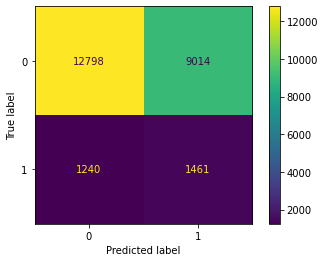

In [86]:
plot_confusion_matrix(knn_model_bal, X_test, y_test)

Сбалансировав данные, удалось уменьшить ошибки второго рода (человек болен, но предсказано, что здоров), т.е. увеличить мощность нашего метода и увеличить число верно отрицательных предсказаний. Однако при этом accuracy упало, что можно было ожидать, потому что для несбалансированных данных моделбь "предполагала", что типичным (из-за большого количества примеров) является состояние "здоров", а потому в любой "непонятной ситуации", модель выбирала вариант "здоров"

### Алгоритм Random Forest

#### Для оригинальных данных

Обучим классификатор на основе алгоритма _Random Forest_

In [87]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

CPU times: user 1min 11s, sys: 2.26 s, total: 1min 14s
Wall time: 1min 17s


RandomForestClassifier(n_estimators=500)

Вычисляем ошибку на тренировочной выборке

In [88]:
%%time
y_train_pred = rf_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 100.00%
         Error on train data: 0.00%
CPU times: user 13.8 s, sys: 597 ms, total: 14.4 s
Wall time: 14.4 s


Вычисляем ошибку на тестовой выборке

In [89]:
%%time
y_test_pred = rf_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.99%
         Error on test  data: 11.01%
CPU times: user 4.26 s, sys: 13.8 ms, total: 4.27 s
Wall time: 5.12 s


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


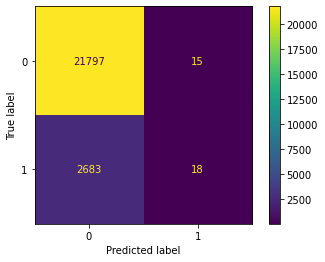

In [90]:
plot_confusion_matrix(rf_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _Random Forest_ не улучшило результаты.

In [91]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

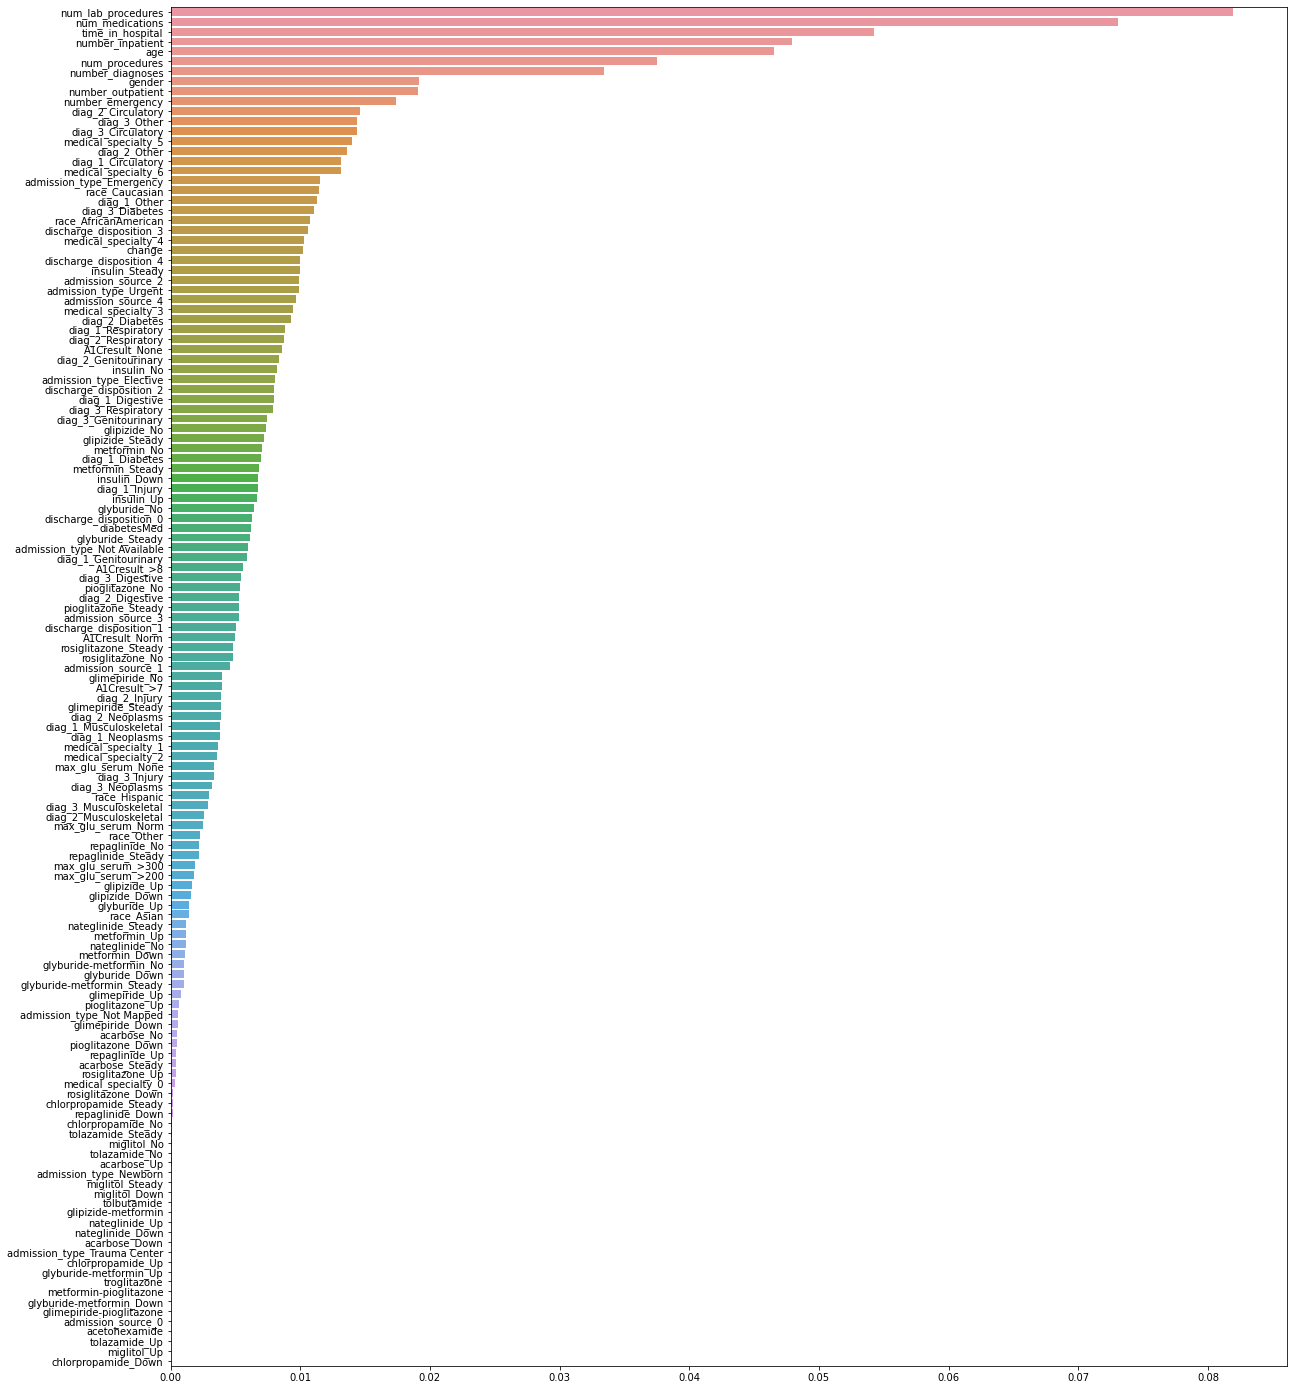

In [92]:
fig = plt.figure(figsize=(20, 25))
sns.barplot(y=importances.index, x=importances, orient='h')
pass

#### Для сбалансированных данных

Обучим классификатор на основе алгоритма _Random Forest_

In [93]:
%%time
rf_model_bal = RandomForestClassifier(n_estimators=500)
rf_model_bal.fit(X_train_bal, y_train_bal)

CPU times: user 24.2 s, sys: 240 ms, total: 24.4 s
Wall time: 24.4 s


RandomForestClassifier(n_estimators=500)

Вычисляем ошибку на сбалансированной тренировочной выборке

In [94]:
%%time
y_train_pred = rf_model_bal.predict(X_train_bal)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train_bal, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train_bal != y_train_pred)))

Accuracy score on train data: 100.00%
         Error on train data: 0.00%
CPU times: user 4.59 s, sys: 25.9 ms, total: 4.62 s
Wall time: 4.61 s


Вычисляем ошибку на тестовой выборке

In [95]:
%%time
y_test_pred = rf_model_bal.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 82.52%
         Error on test  data: 17.48%
CPU times: user 3.95 s, sys: 10.9 ms, total: 3.96 s
Wall time: 3.97 s


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


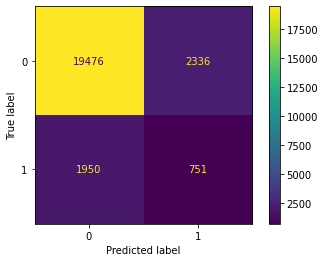

In [96]:
plot_confusion_matrix(rf_model_bal, X_test, y_test)

Замена оригинальных данных на сбалансированные для _Random Forest_ дало такой же эффект, как аналогичная замена для _kNN_. Однако сами результаты далеки до тех, что были получены с помощью _kNN_, а потому можно утверждать, что использование алгоритма _Random Forest_ не улучшило результаты

In [97]:
importances = pd.Series(rf_model_bal.feature_importances_, index=X.columns).sort_values(ascending=False)

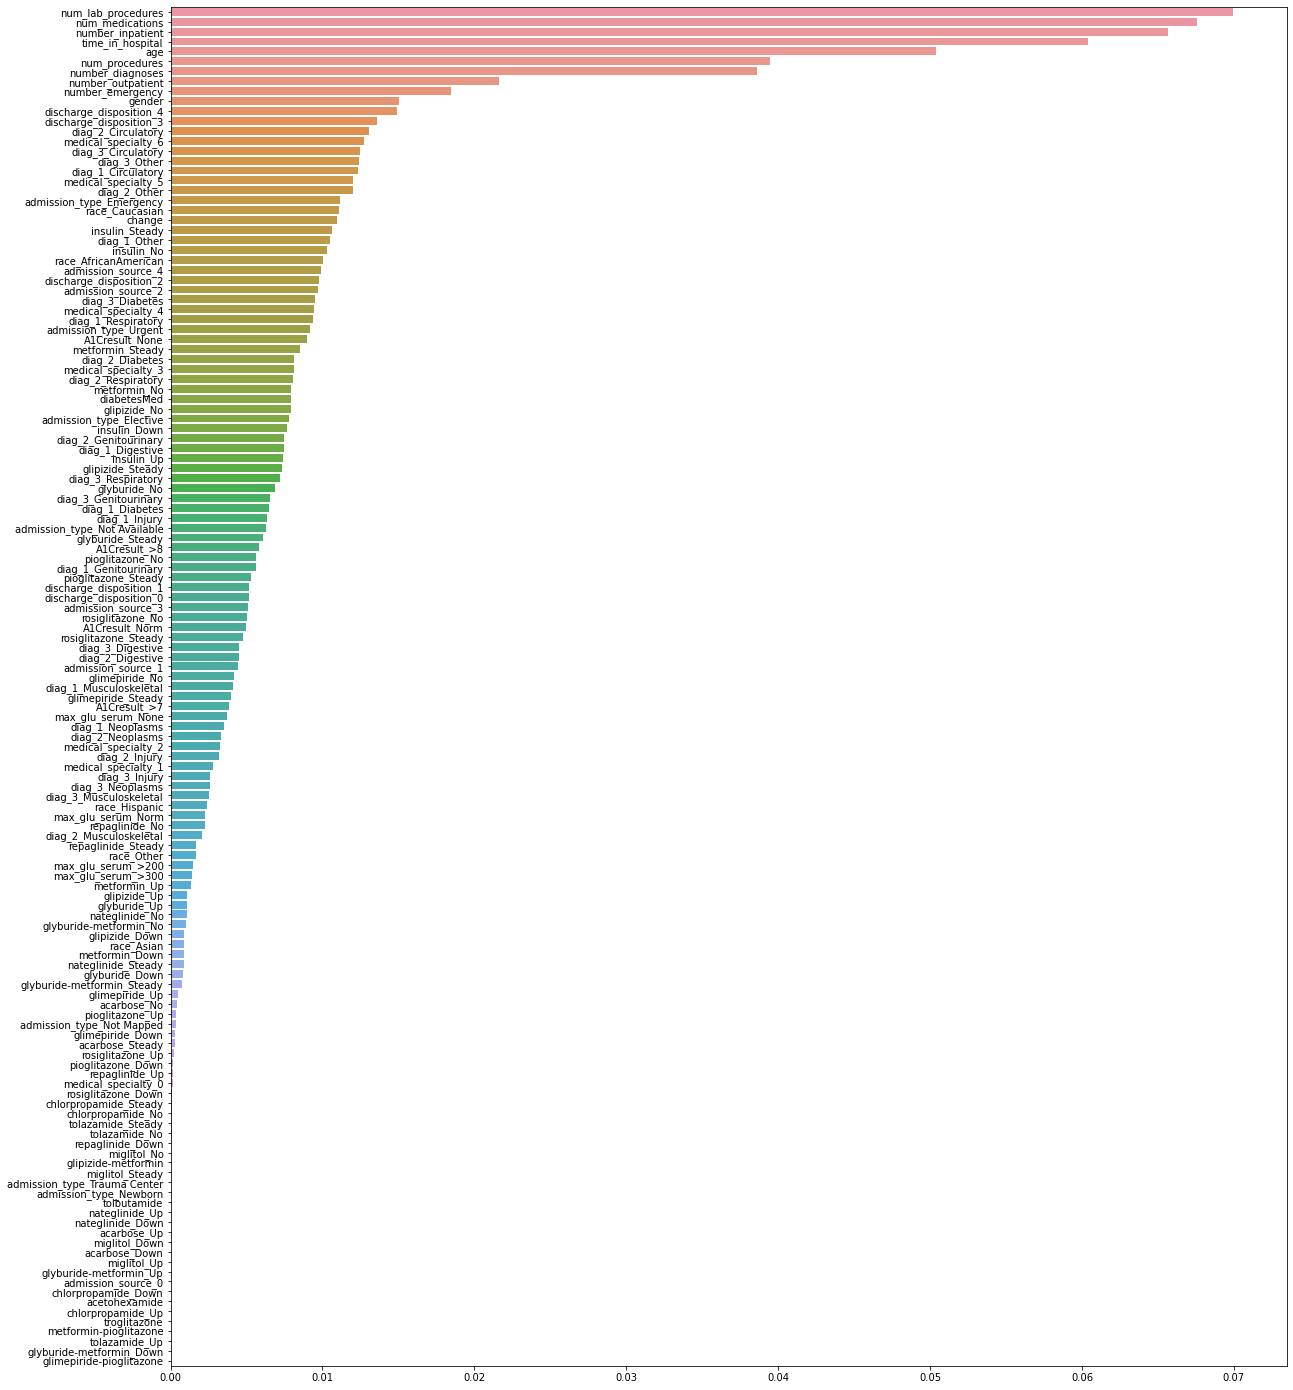

In [98]:
fig = plt.figure(figsize=(20, 25))
sns.barplot(y=importances.index, x=importances, orient='h')
pass

### Алгоритм Logistic Regression

#### Для оригинальных данных

Обучим классификатор на основе алгоритма _Logistic Regression_

In [99]:
%%time

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='newton-cg')
lr_model.fit(X_train, y_train)

CPU times: user 31.3 s, sys: 2.81 s, total: 34.2 s
Wall time: 17.7 s


LogisticRegression(solver='newton-cg')

Вычисляем ошибку на тренировочной выборке

In [100]:
y_train_pred = lr_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.62%
         Error on train data: 11.38%


Вычисляем ошибку на тестовой выборке

In [101]:
y_test_pred = lr_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.90%
         Error on test  data: 11.10%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


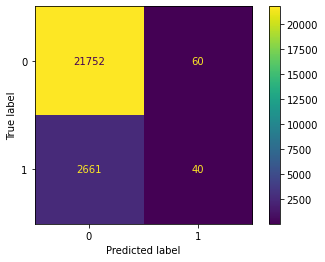

In [102]:
plot_confusion_matrix(lr_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _Logistic Regression_ также не улучшило результаты.

#### Для сбалансированных данных

Обучим классификатор на основе алгоритма _Logistic Regression_

In [103]:
%%time
lr_model_bal = LogisticRegression(solver='newton-cg')
lr_model_bal.fit(X_train_bal, y_train_bal)

CPU times: user 11.3 s, sys: 1.32 s, total: 12.6 s
Wall time: 6.62 s


LogisticRegression(solver='newton-cg')

Вычисляем ошибку на сбалансированной тренировочной выборке

In [104]:
y_train_pred = lr_model_bal.predict(X_train_bal)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train_bal, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train_bal != y_train_pred)))

Accuracy score on train data: 72.89%
         Error on train data: 27.11%


Вычисляем ошибку на тестовой выборке

In [105]:
y_test_pred = lr_model_bal.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 84.50%
         Error on test  data: 15.50%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


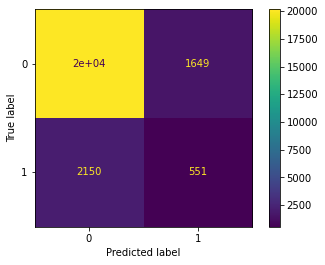

In [106]:
plot_confusion_matrix(lr_model_bal, X_test, y_test)

Замена оригинальных данных на сбалансированные для алгоритма _Logistic Regression_ дало такой же эффект, как аналогичная замена для _kNN_ и _Random Forest_. Однако сами результаты держатся на том же уровне, что и для _Random Forest_ и далеки до тех, что были получены с помощью _kNN_, а потому можно утверждать, что использование алгоритма _Logistic Regression_ не улучшило результаты

### Алгоритм SGDClassifier

#### Для оригинальных данных

Обучим классификатор на основе алгоритма _SGD_

In [107]:
%%time

from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log', random_state=58)
sgd_model.fit(X_train, y_train)

CPU times: user 1.33 s, sys: 542 µs, total: 1.33 s
Wall time: 1.34 s


SGDClassifier(loss='log', random_state=58)

Вычисляем ошибку на тренировочной выборке

In [108]:
y_train_pred = sgd_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.43%
         Error on train data: 11.57%


Вычисляем ошибку на тестовой выборке

In [109]:
y_test_pred = sgd_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.49%
         Error on test  data: 11.51%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


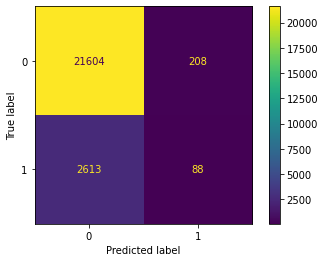

In [110]:
plot_confusion_matrix(sgd_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _SGD_ также не улучшило результаты.

#### Для сбалансированных данных

Обучим классификатор на основе алгоритма _SGD_

In [111]:
%%time
sgd_model_bal = SGDClassifier(loss='log', random_state=58)
sgd_model_bal.fit(X_train_bal, y_train_bal)

CPU times: user 762 ms, sys: 3.81 ms, total: 766 ms
Wall time: 777 ms


SGDClassifier(loss='log', random_state=58)

Вычисляем ошибку на сбалансированной тренировочной выборке

In [112]:
y_train_pred = sgd_model_bal.predict(X_train_bal)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train_bal, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train_bal != y_train_pred)))

Accuracy score on train data: 72.29%
         Error on train data: 27.71%


Вычисляем ошибку на тестовой выборке

In [113]:
y_test_pred = sgd_model_bal.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 87.79%
         Error on test  data: 12.21%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


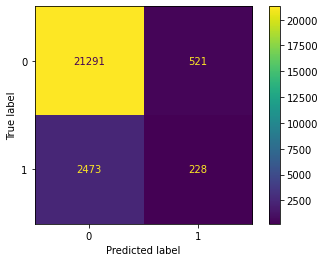

In [114]:
plot_confusion_matrix(sgd_model_bal, X_test, y_test)

Также, как и для всех предыдущих алгоритмов замена оригинальных данных на сбалансированные для _SGD_ снизило ошибку второго рода, однако результаты далеки до тех, что были получены с помощью _kNN_, а потому можно утверждать, что использование алгоритма _SGD_ также не улучшило результаты

## Промежуточные выводы по результатам моделей "классического" ML

* Лучшая точность (accuracy), которой удалось добиться на тестовой выборке - 89% достигнута методом _kNN_ при _k = 20_.
* Ни один из других предложенных алгоритмов не смог добиться лучших результатов.
* По матрицам рассогласования для обученных на оригинальных данных моделей можно сказать, что у всех из них довольно велико значение ошибки второго рода, что опасно.
* Использование сбалансированных данных вместо оригинальных улучшило некоторые показатели, но в ущерб другим. Если же говорить только об ошибке второго рода, то подобная замена во всех рассматриваемых случаях снижает её на определённый процент от первоначального уровня (от приблизительно 10% для _SGD_ вплоть до 50% для _kNN_).
* Метод _kNN_ по времени работает сильно дольше остальных методов.

## Neural Networks

### Cеть с одним скрытым слоем

#### Для оригинальных данных

In [115]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    solver='adam',
    activation='relu',
    random_state=42,
    max_iter=1000
)

In [116]:
%%time
mlp_model.fit(X_train, y_train)

CPU times: user 6min 10s, sys: 3min 27s, total: 9min 38s
Wall time: 5min 4s


MLPClassifier(max_iter=1000, random_state=42)

Вычисляем ошибку на тренировочной выборке

In [117]:
y_train_pred = mlp_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 91.63%
         Error on train data: 8.37%


Вычисляем ошибку на тестовой выборке

In [118]:
y_test_pred = mlp_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 86.08%
         Error on test  data: 13.92%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


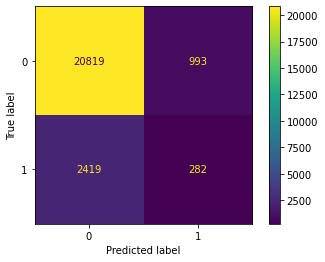

In [119]:
plot_confusion_matrix(mlp_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

#### Для сбалансированных данных

In [120]:
mlp_model_bal = MLPClassifier(
    hidden_layer_sizes=(100,),
    solver='adam',
    activation='relu',
    random_state=42,
    max_iter=1000
)

In [121]:
%%time
mlp_model_bal.fit(X_train_bal, y_train_bal)

CPU times: user 2min 13s, sys: 1min 18s, total: 3min 31s
Wall time: 1min 49s


MLPClassifier(max_iter=1000, random_state=42)

Вычисляем ошибку на сбалансированной тренировочной выборке

In [122]:
y_train_pred = mlp_model_bal.predict(X_train_bal)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train_bal, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train_bal != y_train_pred)))

Accuracy score on train data: 87.35%
         Error on train data: 12.65%


Вычисляем ошибку на тестовой выборке

In [123]:
y_test_pred = mlp_model_bal.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 66.47%
         Error on test  data: 33.53%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


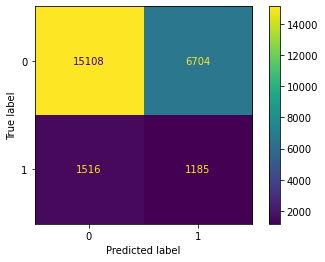

In [124]:
plot_confusion_matrix(mlp_model_bal, X_test, y_test)

Как и ожидалось, замена оригинальных данных на сбалансированные снизило ошибку второго рода (приблизительно на 40%), сильно повысив при этом число "ложных срабатываний" (ошибку первого рода), что сказалось на точности (accuracy)

### Cеть с двумя скрытыми слоями

#### Для оригинальных данных

In [125]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    solver='adam',
    activation='relu',
    random_state=42,
    max_iter=1000
)

In [126]:
%%time
mlp_model.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 1min 9s, total: 2min 33s
Wall time: 1min 32s


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

Вычисляем ошибку на тренировочной выборке

In [127]:
y_train_pred = mlp_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.82%
         Error on train data: 11.18%


Вычисляем ошибку на тестовой выборке

In [128]:
y_test_pred = mlp_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.68%
         Error on test  data: 11.32%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


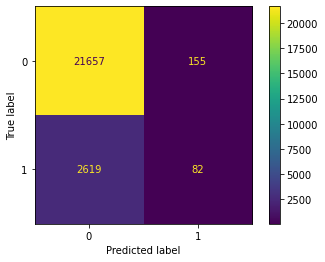

In [129]:
plot_confusion_matrix(mlp_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

#### Для сбалансированных данных

In [130]:
mlp_model_bal = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    solver='adam',
    activation='relu',
    random_state=42,
    max_iter=1000
)

In [131]:
%%time
mlp_model_bal.fit(X_train_bal, y_train_bal)

CPU times: user 24.1 s, sys: 20.4 s, total: 44.5 s
Wall time: 26.1 s


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

Вычисляем ошибку на сбалансированной тренировочной выборке

In [132]:
y_train_pred = mlp_model_bal.predict(X_train_bal)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train_bal, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train_bal != y_train_pred)))

Accuracy score on train data: 74.42%
         Error on train data: 25.58%


Вычисляем ошибку на тестовой выборке

In [133]:
y_test_pred = mlp_model_bal.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 83.73%
         Error on test  data: 16.27%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


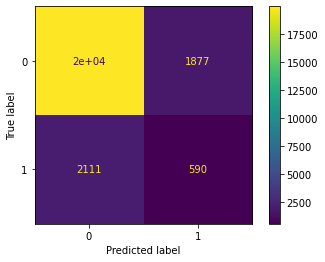

In [134]:
plot_confusion_matrix(mlp_model_bal, X_test, y_test)

Как и ожидалось, замена оригинальных данных на сбалансированные снизило ошибку второго рода (приблизительно на 20%), однако результаты в целом для двух скрытых слоев хуже (особенно по показателю recall), чем для одного, поэтому в данном случае целесообразнее использовать сеть с одним скрытым слоем

### Оптимизация гиперпараметров

#### Поиск оптимальных значений для _alpha_ и _n\_layers_

Подбираем оптимальное значение параметра _alpha_ в диапазоне [-3, 2] разделённом равномерно в логарифмическом масштабе. Подбираем оптимальное количество нейронов в скрытом слое в диапазоне [10, 140) с шагом 10.

In [135]:
alpha_arr = np.logspace(-3, 2, 11)
hidden_layer_sizes_arr = [(n,) for n in range (10, 140, 10)]

In [136]:
%%time
results_train_acc = []
results_train_err = []
results_test_acc = []
results_test_err = []
hyper_params = []

for layer_sizes in hidden_layer_sizes_arr:
    for alpha_value in alpha_arr:
        mlp_model = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            alpha=alpha_value,
            solver='adam',
            activation='relu',
            random_state=42,
            max_iter=1000
        )
        mlp_model.fit(X_train, y_train)
        y_train_pred = mlp_model.predict(X_train)
        acc_train = 100 * accuracy_score(y_train, y_train_pred)
        err_train = 100 * np.mean(y_train != y_train_pred)
        y_test_pred = mlp_model.predict(X_test)
        acc_test = 100 * accuracy_score(y_test,  y_test_pred)
        err_test = 100 * np.mean(y_test != y_test_pred)
        print("[alpha={:.4f}; layer={}]: acc_train={:.2f}%   acc_test={:.2f}%".format(
            alpha_value,
            layer_sizes,
            acc_train,
            acc_test
        ))
        hyper_params.append({'hidden_layer_sizes': layer_sizes, 'alpha': alpha_value})
        results_train_acc.append(acc_train)
        results_train_err.append(err_train)
        results_test_acc.append(acc_test)
        results_test_err.append(err_test)

[alpha=0.0010; layer=(10,)]: acc_train=88.76%   acc_test=88.88%
[alpha=0.0032; layer=(10,)]: acc_train=88.74%   acc_test=88.85%
[alpha=0.0100; layer=(10,)]: acc_train=88.74%   acc_test=88.95%
[alpha=0.0316; layer=(10,)]: acc_train=88.74%   acc_test=88.94%
[alpha=0.1000; layer=(10,)]: acc_train=88.67%   acc_test=88.96%
[alpha=0.3162; layer=(10,)]: acc_train=88.65%   acc_test=88.98%
[alpha=1.0000; layer=(10,)]: acc_train=88.62%   acc_test=88.98%
[alpha=3.1623; layer=(10,)]: acc_train=88.63%   acc_test=88.98%
[alpha=10.0000; layer=(10,)]: acc_train=88.63%   acc_test=88.98%
[alpha=31.6228; layer=(10,)]: acc_train=88.63%   acc_test=88.98%
[alpha=100.0000; layer=(10,)]: acc_train=88.63%   acc_test=88.98%
[alpha=0.0010; layer=(20,)]: acc_train=88.85%   acc_test=88.81%
[alpha=0.0032; layer=(20,)]: acc_train=88.87%   acc_test=88.85%
[alpha=0.0100; layer=(20,)]: acc_train=88.81%   acc_test=88.85%
[alpha=0.0316; layer=(20,)]: acc_train=88.79%   acc_test=88.98%
[alpha=0.1000; layer=(20,)]: acc_tra

In [137]:
arg_max = np.argmax(results_test_acc)
arg_max_params = hyper_params[arg_max]

Оптимальные значения числа нейронов в скрытом слое и _alpha_, а также значения точности для тренировочного и тестового наборов.

In [138]:
arg_max_params, results_train_acc[arg_max], results_test_acc[arg_max]

({'hidden_layer_sizes': (20,), 'alpha': 0.1},
 88.69443424577436,
 89.0221515114429)

In [139]:
alpha_arr = []
train_acc_arr = []
test_acc_arr = []
train_err_arr = []
test_err_arr = []

for i, params in enumerate(hyper_params):
    if (params['hidden_layer_sizes'] == arg_max_params['hidden_layer_sizes']):
        train_acc_arr.append(results_train_acc[i])
        test_acc_arr.append(results_test_acc[i])
        train_err_arr.append(results_train_err[i])
        test_err_arr.append(results_test_err[i])
        alpha_arr.append(params['alpha'])

In [140]:
def plot_acc_vs_alpha(alpha_arr, train_acc, test_acc):
    plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
    plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
    plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
    plt.title('Accuracy vs. alpha')
    plt.xlabel('alpha')
    plt.ylabel('Accuracy')
    plt.legend()

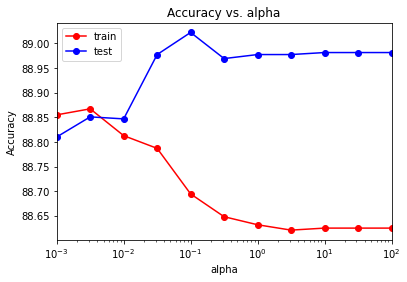

In [141]:
plot_acc_vs_alpha(alpha_arr, train_acc_arr, test_acc_arr)

Значительных изменений в точности при увеличении _alpha_ при фиксированном числе нейронов не наблюдается, даже наоборот, еле заметное ухудшение.

In [142]:
def plot_err_vs_alpha(alpha_arr, train_err, test_err):
    plt.semilogx(alpha_arr, train_err, 'r-o', label = 'train')
    plt.semilogx(alpha_arr, test_err, 'b-o', label = 'test')
    plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
    plt.title('Error vs. alpha')
    plt.xlabel('alpha')
    plt.ylabel('Error')
    plt.legend()

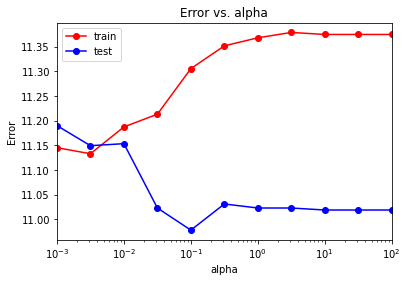

In [143]:
plot_err_vs_alpha(alpha_arr, train_err_arr, test_err_arr)

Заново обучим MLP-классификатор с найденными оптимальными гиперпараметрами и оценим качество его работы, построив матрицу рассогласования.

In [144]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=arg_max_params['hidden_layer_sizes'],
    alpha=arg_max_params['alpha'],
    solver='adam',
    activation='relu',
    random_state=42,
    max_iter=1000
)

In [145]:
%%time
mlp_model.fit(X_train, y_train)

CPU times: user 31.5 s, sys: 21.9 s, total: 53.4 s
Wall time: 27.7 s


MLPClassifier(alpha=0.1, hidden_layer_sizes=(20,), max_iter=1000,
              random_state=42)

Вычисляем ошибку на тренировочной выборке

In [146]:
y_train_pred = mlp_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.69%
         Error on train data: 11.31%


Вычисляем ошибку на тестовой выборке

In [147]:
y_test_pred = mlp_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 89.02%
         Error on test  data: 10.98%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


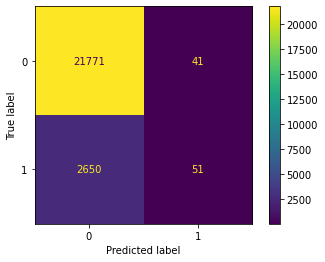

In [148]:
plot_confusion_matrix(mlp_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели даже с оптимальными гиперпараметрами оставляет желать лучшего.

### Выводы

* Подбор оптимальных значения гиперпараметров позволил повысить точность на тестовой выборке.
* Лучше всех (по accuracy) себя проявил _MLP_ (при _alpha_=0.1, с 20 нейронами в скрытом слое) с точностью 89.02%.
* Использование _MLP_ классификатора не сильно увеличило точность по сравнению с другими классификаторами (лучший показатель точности для _kNN_ - 89.00%, для _MLP_ - 89.02%).
* Все использованные алгоритмы показывают приблизительно похожую лучшую точность предсказывания на тестовой выборке среди моделей, обученных на оригинальных данных.
* Использование сбалансированных данных вместо оригинальных улучшило некоторые показатели, но в ущерб другим. Если же говорить только об ошибке второго рода, то подобная замена во всех рассматриваемых случаях снижает её.
* Метод _MLP_ по времени работает сильно дольше остальных методов. По этому показателю сравним лишь с _kNN_.